## objectives of preprocessing
    
- data should be 2D array
- input data has to be numbers
- no nan or inf
- coloum are scaled to similar ranges (mean=0, variance=1)
- coloums should not be coliner (cx1!=k*cx2)
- rows should not be causally dependent
- data should be 100 times larger then the number of coloums 

## import python libraries 

In [1]:
import os
import pathlib
from pprint import pprint
from pathlib import Path
import csv

In [2]:
import ray
import rasterio
import fiona
import pandas as pd
import xgboost as xgb
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import matplotlib.pyplot as plt

In [3]:
%load_ext memory_profiler

## define input datasets

- features 
- targets 
- out of sample 
- area of interest

In [48]:
%%time

feature_file_paths = [
Path('/g/data/ge3/sheece/LOC_distance_to_coast.tif'),
Path('/g/data/ge3/sheece/mrvbf_9.tif'),
Path('/g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif'),
Path('/g/data/ge3/sheece/relief_elev_focalrange1000m_3s.tif'),
Path('/g/data/ge3/sheece/relief_elev_focalrange300m_3s.tif'),
Path('/g/data/ge3/sheece/saga_wetSM_85.tif'),
Path('/g/data/ge3/sheece/tpi_300.tif'),
Path('/g/data/ge3/sheece/slope_fill2.tif'),
Path('/g/data/ge3/sheece/dem_fill.tif'),
Path('/g/data/ge3/sheece/3dem_mag2.tif'),
Path('/g/data/ge3/sheece/3dem_mag1_fin.tif'),
Path('/g/data/ge3/sheece/3dem_mag0.fin.tif'),
Path('/g/data/ge3/sheece/relief_roughness.tif'),
Path('/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif'),
Path('/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif'),
Path('/g/data/ge3/sheece/Dose_2016.tif'),
Path('/g/data/ge3/sheece/Potassium_2016.tif'),
Path('/g/data/ge3/sheece/Thorium_2016.tif'),
Path('/g/data/ge3/sheece/Rad2016U_Th.tif'),
Path('/g/data/ge3/sheece/Rad2016K_Th.tif'),
Path('/g/data/ge3/sheece/national_Wii_RF_multirandomforest_prediction.tif'),
Path('/g/data/ge3/sheece/si_geol1.tif'),
Path('/g/data/ge3/sheece/ceno_euc_aust1.tif'),
Path('/g/data/ge3/sheece/Grav_lane_clip.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg_BLUE+SWIR2.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-RED.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-GREEN.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-l8-all-85m-avg-BLUE.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-l8-all-85m-avg-NIR.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-SWIR1.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-SWIR2.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/s2-dpca-85m.tif'),
Path('/g/data/ge3/sheece/water-85m.tif'),
Path('/g/data/ge3/sheece/clim_EPA_albers.tif'),
Path('/g/data/ge3/sheece/Clim_Prescott_LindaGregory.tif'),
Path('/g/data/ge3/sheece/clim_PTA_albers.tif'),
Path('/g/data/ge3/sheece/clim_WDA_albers.tif'),
Path('/g/data/ge3/sheece/clim_RSM_albers.tif')
]

#target dataset small
# /g/data/ge3/sheece/0_50cm_2021_albers_C_sm_T_resampled_small.shp
#target dataset complete
# /g/data/ge3/sheece/0_50cm_2021_albers_C_sm_T_resampled.shp
target_file_path = Path("/g/data/ge3/sheece/0_50cm_2021_albers_C_sm_T_resampled.shp")

# define a shape for area of intrest
area_of_interest_file_path = None

#OOS
# /g/data/ge3/sheece/0_50cm_2021_albers_C_oos.shp
out_of_sample_file_path = Path("/g/data/ge3/sheece/0_50cm_2021_albers_C_oos.shp")

root = Path('/g/data/ge3/sheece')

CPU times: user 419 µs, sys: 584 µs, total: 1 ms
Wall time: 959 µs


In [49]:
# remove duplicates

temp_feature_file_paths = feature_file_paths.copy()
unique_values = list(set(temp_feature_file_paths))
for unique_value in unique_values:
    temp_feature_file_paths.remove(unique_value)

print("Following are duplicates:")
print(temp_feature_file_paths)

feature_file_paths = list(set(feature_file_paths))

Following are duplicates:
[PosixPath('/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif'), PosixPath('/g/data/ge3/sheece/be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata.tif')]


In [50]:
# check if file exist
import os.path

for feature_file_path in feature_file_paths:
    if not os.path.isfile(feature_file_path):
        feature_file_paths.remove(feature_file_path)
        print ("File not exist",feature_file_path)
    
        


In [51]:
if not os.path.isdir(root/"old"):
    os.mkdir(root/"old") 

## Standardising Datasets

In [52]:
# check if all datasets have only one band
import shutil

for feature_file_path in feature_file_paths:
    with rasterio.open(feature_file_path) as dataset:
        if len(dataset.indexes) >1: 
            print("Processing dataset: ",feature_file_path)
            for band in dataset.indexes:
                path_to_new_dataset = root/ str(feature_file_path.stem +"_"+str(band)+".tif")
                print("Reading data from band: ",band)
                new_dataset = rasterio.open(
                    path_to_new_dataset,
                     'w',
                     driver='GTiff',
                     height=dataset.shape[0],
                     width=dataset.shape[1],
                     count=1,
                     dtype=dataset.meta['dtype'],
                     crs=dataset.crs,
                     transform=dataset.transform
                )
                
                new_dataset.write(dataset.read(band),1)
                new_dataset.close()
                print("New dataset added:",path_to_new_dataset)
                feature_file_paths.append(path_to_new_dataset)
    
            print("Removing multiband dataset:",feature_file_path)
            feature_file_paths.remove(feature_file_path)

Processing dataset:  /g/data/ge3/sheece/s2-dpca-85m.tif
Reading data from band:  1
New dataset added: /g/data/ge3/sheece/s2-dpca-85m_1.tif
Reading data from band:  2
New dataset added: /g/data/ge3/sheece/s2-dpca-85m_2.tif
Reading data from band:  3
New dataset added: /g/data/ge3/sheece/s2-dpca-85m_3.tif
Removing multiband dataset: /g/data/ge3/sheece/s2-dpca-85m.tif
Processing dataset:  /g/data/ge3/sheece/water-85m.tif
Reading data from band:  1
New dataset added: /g/data/ge3/sheece/water-85m_1.tif
Reading data from band:  2
New dataset added: /g/data/ge3/sheece/water-85m_2.tif
Reading data from band:  3
New dataset added: /g/data/ge3/sheece/water-85m_3.tif
Removing multiband dataset: /g/data/ge3/sheece/water-85m.tif


In [53]:
# check if all datasets are in same projections 
import shutil
from rasterio.warp import calculate_default_transform, reproject, Resampling

# check projection 
crs_epsg3577 = rasterio.crs.CRS.from_string('EPSG:3577')

for feature_file_path in feature_file_paths:
    with rasterio.open(feature_file_path) as src:
        if crs_epsg3577 != src.crs:
            print("Converting dataset: "+str(feature_file_path))
            transform, width, height = calculate_default_transform(
                src.crs, 
                crs_epsg3577, 
                src.width, 
                src.height, 
                *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({'crs': crs_epsg3577,'transform': transform, 'width': width,'height': height})

            new_feature_file_path = feature_file_path.parent /str(feature_file_path.stem+"_reprojected.tif")
            with rasterio.open(new_feature_file_path, 'w', **kwargs) as dst:
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs_epsg3577,
                    resampling=Resampling.nearest)
            feature_file_paths.remove(feature_file_path)
            feature_file_paths.append(new_feature_file_path)
            print("Dataset: ",feature_file_path, " has been reprojected and saved as: ",new_feature_file_path)


Converting dataset: /g/data/ge3/sheece/saga_wetSM_85.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99999.0, 'width': 37085, 'height': 18982, 'count': 1, 'crs': CRS.from_epsg(3577), 'transform': Affine(84.99895098729797, 0.0, -1555680.0000045914,
       0.0, -84.99895098729797, -1052891.999967362)}
Dataset:  /g/data/ge3/sheece/saga_wetSM_85.tif  has been reprojected and saved as:  /g/data/ge3/sheece/saga_wetSM_85_reprojected.tif


In [54]:
# apply crop on target and feature datasets according to area of intrest 
import fiona
import rasterio
from rasterio.mask import mask

if area_of_interest_file_path is not None:
    with fiona.open(area_of_interest_file_path) as shapefile:
        geoms = [feature["geometry"] for feature in shapefile]

    for feature_file_path in feature_file_paths:
        if "cropped" not in feature_file_path.name:
            print("Cropping : "+feature_file_path.stem)
            # load the raster, mask it by the polygon and crop it
            with rasterio.open(feature_file_path) as src:
                out_image, out_transform = mask(src, geoms, crop=True)
            out_meta = src.meta.copy()

            # save the resulting raster  
            out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
            })   

            with rasterio.open(root/(feature_file_path.stem+'_cropped.tif'), "w", **out_meta) as dest:
                dest.write(out_image)

            shutil.move(feature_file_path, root/("old/"+feature_file_path.name))

In [55]:
# apply crop vector files(.shp)
import subprocess

if area_of_interest_file_path is not None:
    if "cropped" not in target_file_path.name:
        print("Cropping: "+target_file_path.name)
        clipped_file = root/(target_file_path.stem+'_cropped.shp')
        callstr = ['ogr2ogr',
                   '-clipsrc',
                   area_of_interest_file_path,
                   clipped_file,
                   target_file_path] 
        proc = subprocess.Popen(callstr, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        stdout,stderr=proc.communicate()

        shutil.move(target_file_path, root/("old/"+target_file_path.name))

In [62]:
# create iterators ( C++ pointers) to inputs feature dataset and target dataset
datasets = []
for feature_file_path in feature_file_paths: 
    datasets.append(rasterio.open(feature_file_path))

target_handle = fiona.open(target_file_path)

In [63]:
%%time
%%memit

head_row = ['target']
for feature_file_path in feature_file_paths:
    head_row.append(feature_file_path.stem)
head_row.append("x")
head_row.append("y")
    
csv_rowlist = [head_row]
with open('../data/input_dataset.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # iterate through list of targets
    for target in target_handle:
        value = target["properties"]["con"]
        x, y = target["geometry"]["coordinates"]
        new_row = [value]
        
        # iterate through list of features
        for dataset in datasets:
            new_row.append(next(dataset.sample([(x, y)]))[0])
        new_row.append(x)
        new_row.append(y)
        
        csv_rowlist.append(new_row)

        if len(csv_rowlist)%1000==0:
            writer.writerows(csv_rowlist)
            csv_rowlist = []

peak memory: 11161.31 MiB, increment: 194.16 MiB
CPU times: user 20min 49s, sys: 2min 47s, total: 23min 36s
Wall time: 31min 20s


In [65]:
!pwd

/home/547/sg4953/uncoverml/notebook


In [64]:
target_handle.close()
for dataset in datasets: 
    dataset.close()

## Cleaning dataset

In [5]:
input_file = '../data/input_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
input_shape = df.shape
df = df.drop(["x","y"],axis=1).astype('float32') 
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]

df.to_csv("../data/formated_dataset.csv",index=None,header=df.columns.values)
output_shape = df.shape
print("Number of rows removed: ",input_shape[0]-output_shape[0])


input_file:  ../data/input_dataset.csv
Number of rows removed:  1682


## Exploring Normalization
- Rescaling (min-max normalization)
- Standardization (Z-scale normalization)



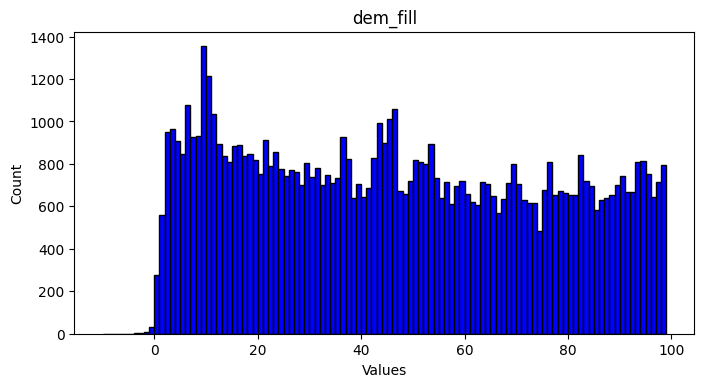

In [270]:
## density plots for input features
dataset_id = 23
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
col_name = df.columns.values[dataset_id]
plt.xlabel('Values')
plt.ylabel('Count')
plt.title(col_name)
_ = plt.hist(df[col_name], color = 'blue', edgecolor = 'black', bins = np.arange(-10,100,1),label=col_name )

In [8]:
scaler = preprocessing.StandardScaler().fit(df)
scaled_df = scaler.transform(df)

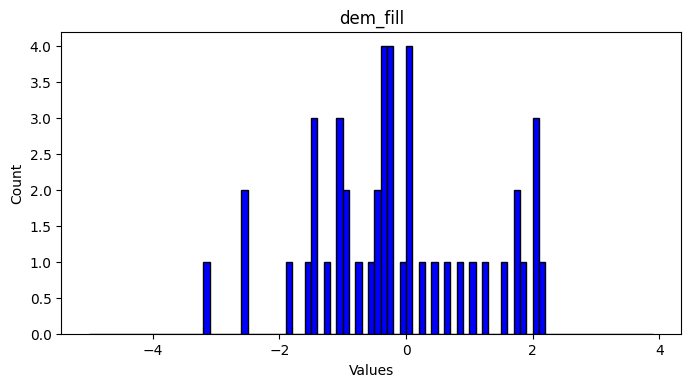

In [271]:


plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
col_name = df.columns.values[dataset_id]
plt.xlabel('Values')
plt.ylabel('Count')
plt.title(col_name)
_ = plt.hist(scaled_df[dataset_id], color = 'blue', edgecolor = 'black', bins = np.arange(-5,4,0.1),label=col_name )

In [230]:
scaler = preprocessing.QuantileTransformer().fit(df)
quantile_df = scaler.transform(df)

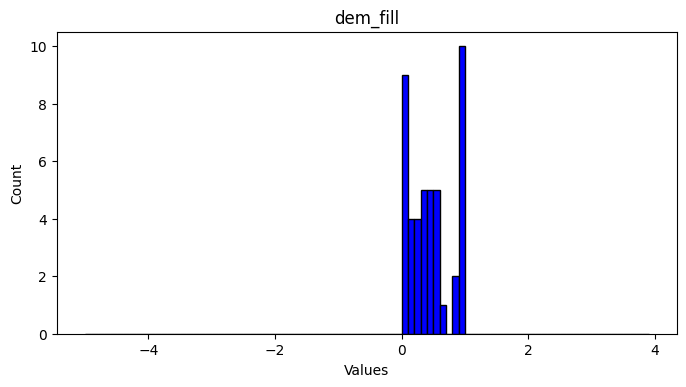

In [272]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
col_name = df.columns.values[dataset_id]
plt.xlabel('Values')
plt.ylabel('Count')
plt.title(col_name)
_ = plt.hist(quantile_df[dataset_id], color = 'blue', edgecolor = 'black', bins = np.arange(-5,4,0.1),label=col_name )

## save normalized dataset

In [6]:
def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

input_file = '../data/formated_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
df = maximum_absolute_scaling(df)
df.to_csv("../data/max_abs_df.csv",index=None,header=df.columns.values)
print("output_file: ../data/max_abs_df.csv")

input_file:  ../data/formated_dataset.csv
output_file: ../data/max_abs_df.csv


In [7]:
input_file = '../data/formated_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
scaler = preprocessing.QuantileTransformer().fit(df)
quantile_df = scaler.transform(df)
pd.DataFrame(quantile_df).to_csv("../data/quantile_df.csv",index=None,header=df.columns.values)
print("output: quantile_df")


input_file:  ../data/formated_dataset.csv


In [8]:
input_file = '../data/formated_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
scaler = preprocessing.StandardScaler().fit(df)
scaled_df = scaler.transform(df)
pd.DataFrame(quantile_df).to_csv("../data/scaler_df.csv",index=None,header=df.columns.values)
print("output: scaler_df")


input_file:  ../data/formated_dataset.csv
output: scaler_df
